In [1]:
!pip install pandas numpy scikit-learn openpyxl catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate, RepeatedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error

from catboost import CatBoostRegressor


In [3]:
path = "/content/multiple_variety_dataset-2022.xlsx"

df_target = pd.read_excel(path, sheet_name="Plant_nitrogen_content")
df_features = pd.read_excel(path, sheet_name="VI")

df = df_features.merge(
    df_target[["idplot", "PNC"]],
    on="idplot",
    how="inner"
)

X = df.drop(columns=["PNC", "idplot"])
y = df["PNC"]


In [13]:
stats = {
    "count": y.count(),
    "mean": y.mean(),
    "std": y.std(ddof=1),          # стандартное отклонение
    "var": y.var(ddof=1),          # дисперсия
    "min": y.min(),
    "25%": y.quantile(0.25),
    "median": y.median(),
    "75%": y.quantile(0.75),
    "max": y.max(),
    "iqr": y.quantile(0.75) - y.quantile(0.25)
}

stats_df = pd.DataFrame(stats, index=["PNC"])
print(stats_df)

     count    mean       std       var       min       25%    median  \
PNC    176  1.3237  0.218523  0.047752  0.860113  1.147357  1.338588   

          75%       max       iqr  
PNC  1.499357  1.795949  0.351999  

RMSE / std(y): 0.5994805308118382


In [6]:
numeric_features = X.columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features)
])


In [7]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),

    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),

    "CatBoost": CatBoostRegressor(
        iterations=500,
        depth=6,
        learning_rate=0.05,
        loss_function="RMSE",
        verbose=0,
        random_seed=42
    )
}

Reference DM (t/ha) and corresponding Nc (%N):
  veg_meanDM  : DM=10.31 -> Nc=1.908%
  rep_meanDM  : DM=18.16 -> Nc=1.485%
  pooled_meanDM: DM=15.22 -> Nc=1.606%


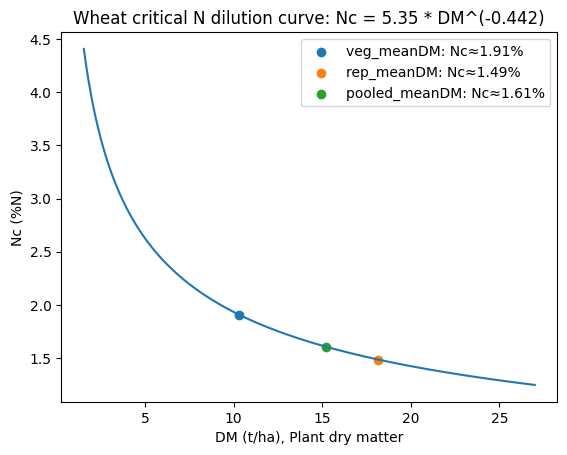

In [21]:
def Nc_wheat(dm_t_ha: np.ndarray | float, a: float = 5.35, b: float = 0.442) -> np.ndarray:
    """
    Critical N concentration for wheat:
    Nc(%) = a * DM^{-b}, DM in t/ha (dry matter).
    """
    dm_t_ha = np.asarray(dm_t_ha, dtype=float)
    return a * (dm_t_ha ** (-b))

# --- Средние DM из Supplementary S1 (Table S3): Plant DMW mean (t/ha) ---
DM_REF = {
    "veg_meanDM": 10.31,    # GS 31–50
    "rep_meanDM": 18.16,    # GS 70–90
    "pooled_meanDM": 15.22  # all pooled
}

Nc_REF = {k: float(Nc_wheat(v)) for k, v in DM_REF.items()}

print("Reference DM (t/ha) and corresponding Nc (%N):")
for k in DM_REF:
    print(f"  {k:12s}: DM={DM_REF[k]:5.2f} -> Nc={Nc_REF[k]:.3f}%")

# График Nc(DM) в диапазоне, который покрывает их данные (у них DM доходил примерно до ~27)
dm_grid = np.linspace(1.55, 27.0, 600)
nc_grid = Nc_wheat(dm_grid)

plt.figure()
plt.plot(dm_grid, nc_grid)
plt.xlabel("DM (t/ha), Plant dry matter")
plt.ylabel("Nc (%N)")
plt.title("Wheat critical N dilution curve: Nc = 5.35 * DM^(-0.442)")

for k in ["veg_meanDM", "rep_meanDM", "pooled_meanDM"]:
    plt.scatter([DM_REF[k]], [Nc_REF[k]], label=f"{k}: Nc≈{Nc_REF[k]:.2f}%")

plt.legend()
plt.show()


In [22]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

def repeated_oof_predict(pipe, X, y, cv):
    """
    OOF prediction for RepeatedKFold:
    each sample is predicted multiple times; we average per sample.
    """
    n = len(y)
    preds_sum = np.zeros(n, dtype=float)
    preds_cnt = np.zeros(n, dtype=int)

    X_get = (lambda idx: X.iloc[idx]) if hasattr(X, "iloc") else (lambda idx: X[idx])
    y_get = (lambda idx: y.iloc[idx]) if hasattr(y, "iloc") else (lambda idx: y[idx])

    for tr_idx, te_idx in cv.split(X, y):
        pipe_fold = Pipeline(pipe.steps)  # simple clone
        pipe_fold.fit(X_get(tr_idx), y_get(tr_idx))
        pred = pipe_fold.predict(X_get(te_idx))
        preds_sum[te_idx] += pred
        preds_cnt[te_idx] += 1

    if (preds_cnt == 0).any():
        raise RuntimeError("Some samples were never predicted. Check CV splits.")

    return preds_sum / preds_cnt

# --- результаты по моделям ---
results = {}
y_std = y.std(ddof=1)

# сюда складываем OOF предсказания PNC (чтобы потом считать NNI без переобучения)
oof_pnc_by_model = {}

scoring = {
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "R2": "r2"
}

for name, model in models.items():
    if name == "CatBoost":
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("model", model)
        ])
    else:
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])

    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_estimator=True)

    mean_rmse = -scores["test_RMSE"].mean()
    mean_r2 = scores["test_R2"].mean()
    relative_rmse = mean_rmse / y_std

    results[name] = {
        "RMSE": mean_rmse,
        "R2": mean_r2,
        "RMSE/std(y)": relative_rmse
    }

    # OOF предсказания PNC (один раз)
    y_pred_oof = repeated_oof_predict(pipe, X, y, cv=cv)
    oof_pnc_by_model[name] = y_pred_oof

    # Feature importance как было
    if name in ["RandomForest", "CatBoost"]:
        est = scores["estimator"][0].named_steps["model"]
        if name == "RandomForest":
            importances = est.feature_importances_
        else:
            importances = est.get_feature_importance()
        feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
        print(f"\nFeature importance ({name}):")
        display(feat_imp.head(10))

results_df = pd.DataFrame(results).T.sort_values("RMSE")
print("\nSummary of models:")
display(results_df)

baseline_rmse = np.sqrt(np.mean((y - y.mean())**2))
print(f"\nBaseline (predict mean) RMSE: {baseline_rmse:.4f}, RMSE/std(y): {baseline_rmse/y_std:.4f}")

print("\nSaved OOF predictions per model in: oof_pnc_by_model")


Feature importance (RandomForest):


,0
VI.37,0.303945
VI.36,0.052823
VI.14,0.050327
VI.15,0.044579
VI.19,0.044377
VI.42,0.043845
VI.41,0.039512
VI.22,0.038300
VI.40,0.038210
VI.5,0.031263



Feature importance (CatBoost):


,0
VI.19,10.984900
VI.41,5.938910
VI.22,5.796711
VI.40,5.460176
VI.31,4.718818
VI.16,4.143074
VI.37,4.140065
VI.24,3.925052
VI.42,3.913606
VI.15,3.724009



Summary of models:


,RMSE,R2,RMSE/std(y)
CatBoost,0.133980,0.602820,0.613116
RandomForest,0.135593,0.589522,0.620500
Ridge,0.137807,0.579108,0.630630
Lasso,0.140872,0.562660,0.644655
LinearRegression,0.163010,0.385974,0.745966



Baseline (predict mean) RMSE: 0.2179, RMSE/std(y): 0.9972

Saved OOF predictions per model in: oof_pnc_by_model


In [24]:
def nni_stats(nni: np.ndarray) -> pd.Series:
    s = pd.Series(np.asarray(nni, dtype=float))
    out = s.describe(percentiles=[0.25, 0.5, 0.75]).copy()
    out["iqr"] = out["75%"] - out["25%"]
    out["share_deficient(<0.9)"] = (s < 0.9).mean()
    out["share_sufficient(0.9-1.1)"] = ((s >= 0.9) & (s <= 1.1)).mean()
    out["share_excess(>1.1)"] = (s > 1.1).mean()
    return out

def compute_nni_from_oof(oof_pnc: np.ndarray, dm_t_ha: float | np.ndarray) -> np.ndarray:
    """
    Given OOF predicted PNC (%N) and DM (t/ha), compute NNI = PNC / Nc(DM).
    dm_t_ha can be scalar or array-like:
      - scalar -> same Nc for all samples
      - array of shape (n_samples,) -> per-sample Nc
    """
    nc = Nc_wheat(dm_t_ha)
    return oof_pnc / nc


for model_name, oof_pnc in oof_pnc_by_model.items():
    nni_veg = compute_nni_from_oof(oof_pnc, DM_REF["veg_meanDM"])
    nni_rep = compute_nni_from_oof(oof_pnc, DM_REF["rep_meanDM"])
    nni_all = compute_nni_from_oof(oof_pnc, DM_REF["pooled_meanDM"])

    df = pd.DataFrame({
        f"veg(DM={DM_REF['veg_meanDM']})": nni_stats(nni_veg),
        f"rep(DM={DM_REF['rep_meanDM']})": nni_stats(nni_rep),
        f"all(DM={DM_REF['pooled_meanDM']})": nni_stats(nni_all),
    })

    print(f"\nNNI stats for model: {model_name}")
    display(df)


NNI stats for model: LinearRegression


,veg(DM=10.31),rep(DM=18.16),all(DM=15.22)
count,176.000000,176.000000,176.000000
mean,0.692435,0.889299,0.822519
std,0.110372,0.141752,0.131108
min,0.357140,0.458677,0.424234
25%,0.600537,0.771274,0.713357
50%,0.723943,0.929765,0.859946
75%,0.770622,0.989716,0.915395
max,1.058023,1.358827,1.256789
iqr,0.170085,0.218442,0.202038
share_deficient(<0.9),0.988636,0.409091,0.676136



NNI stats for model: Ridge


,veg(DM=10.31),rep(DM=18.16),all(DM=15.22)
count,176.000000,176.000000,176.000000
mean,0.693170,0.890243,0.823392
std,0.092638,0.118975,0.110041
min,0.484049,0.621668,0.574985
25%,0.615688,0.790733,0.731354
50%,0.715313,0.918682,0.849695
75%,0.771238,0.990506,0.916126
max,0.929038,1.193170,1.103571
iqr,0.155549,0.199773,0.184771
share_deficient(<0.9),0.994318,0.454545,0.681818



NNI stats for model: Lasso


,veg(DM=10.31),rep(DM=18.16),all(DM=15.22)
count,176.000000,176.000000,176.000000
mean,0.693617,0.890817,0.823923
std,0.084399,0.108394,0.100255
min,0.467335,0.600201,0.555130
25%,0.625926,0.803881,0.743516
50%,0.711094,0.913263,0.844683
75%,0.760470,0.976677,0.903336
max,0.854075,1.096894,1.014525
iqr,0.134544,0.172796,0.159820
share_deficient(<0.9),1.000000,0.443182,0.721591



NNI stats for model: RandomForest


,veg(DM=10.31),rep(DM=18.16),all(DM=15.22)
count,176.000000,176.000000,176.000000
mean,0.692688,0.889624,0.822819
std,0.092680,0.119030,0.110091
min,0.503758,0.646981,0.598397
25%,0.594068,0.762966,0.705672
50%,0.731762,0.939806,0.869234
75%,0.758723,0.974433,0.901260
max,0.869785,1.117071,1.033186
iqr,0.164654,0.211467,0.195587
share_deficient(<0.9),1.000000,0.357955,0.738636



NNI stats for model: CatBoost


,veg(DM=10.31),rep(DM=18.16),all(DM=15.22)
count,176.000000,176.000000,176.000000
mean,0.693075,0.890121,0.823279
std,0.092123,0.118314,0.109429
min,0.517895,0.665136,0.615189
25%,0.607889,0.780716,0.722089
50%,0.724425,0.930384,0.860519
75%,0.761190,0.977602,0.904191
max,0.858082,1.102041,1.019285
iqr,0.153301,0.196886,0.182101
share_deficient(<0.9),1.000000,0.380682,0.727273
